# AtariSpace

This task will not "play" atari but rather simply explore it. That is, there are no rewards, just a (nearly) passive viewing of the different games. The network can take actions within a game, or can cycle between the list of games, but is not rewarded by game score. Instead the network simply watches the games and tries to predict future frames. 

## VNet
This "visual" network is simply an autoencoder. The bottleneck layer is treated as a latent variable (LV). It is convolutional with tied encoder-decoder weights. 

## HNet
This "hippocampal" network takes in the current LV and tries to predict the next LV. This assumes that VNet is relatively constant (low learning rate or frozen). This should have a high LR, and use memory augmentation to preserve long-term dependencies.

## MNet
A small "motor"  network will be trained to maximize prediction errors as a method to encourage exploration. Prediction error is a positive scalar and there is an ideal "Goldilocks zone" for exploration which we approximate with an Erlang distribution.
This could just be random actions, but if any useful exploration policies are learned then great. 

## Environment notes
Any input from any game is allowed (0-17), and ideally MNet should learn which inputs are actually useful in a given game. Two more inputs will allow for cycling between games.

In [1]:
import gymnasium as gym
import math
import random, datetime, os, copy, time
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"

/export03/data/opt/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
possible_actions = 17 # possible actions in all games (inc 0)
games = ['ALE/Tetris-v5', 'ALE/Adventure-v5', 'ALE/AirRaid-v5', 'ALE/Alien-v5', 'ALE/Amidar-v5', 'ALE/Assault-v5', 'ALE/Asterix-v5', 
         'ALE/Asteroids-v5', 'ALE/Atlantis-v5', 'ALE/Atlantis2-v5', 'ALE/Backgammon-v5', 'ALE/BankHeist-v5', 'ALE/BasicMath-v5', 
         'ALE/BattleZone-v5', 'ALE/BeamRider-v5', 'ALE/Berzerk-v5', 'ALE/Blackjack-v5', 'ALE/Bowling-v5', 'ALE/Boxing-v5', 'ALE/Breakout-v5', 
         'ALE/Carnival-v5', 'ALE/Casino-v5', 'ALE/Centipede-v5', 'ALE/ChopperCommand-v5', 'ALE/CrazyClimber-v5', 'ALE/Crossbow-v5', 
         'ALE/Darkchambers-v5', 'ALE/Defender-v5', 'ALE/DemonAttack-v5', 'ALE/DonkeyKong-v5', 'ALE/DoubleDunk-v5', 'ALE/Earthworld-v5', 
         'ALE/ElevatorAction-v5', 'ALE/Enduro-v5', 'ALE/Entombed-v5', 'ALE/Et-v5', 'ALE/FishingDerby-v5', 'ALE/FlagCapture-v5', 
         'ALE/Freeway-v5', 'ALE/Frogger-v5', 'ALE/Frostbite-v5', 'ALE/Galaxian-v5', 'ALE/Gopher-v5', 'ALE/Gravitar-v5', 'ALE/Hangman-v5', 
         'ALE/HauntedHouse-v5', 'ALE/Hero-v5', 'ALE/HumanCannonball-v5', 'ALE/IceHockey-v5', 'ALE/Jamesbond-v5', 'ALE/JourneyEscape-v5', 
         'ALE/Kaboom-v5', 'ALE/Kangaroo-v5', 'ALE/KeystoneKapers-v5', 'ALE/KingKong-v5', 'ALE/Klax-v5', 'ALE/Koolaid-v5', 'ALE/Krull-v5', 
         'ALE/KungFuMaster-v5', 'ALE/LaserGates-v5', 'ALE/LostLuggage-v5', 'ALE/MarioBros-v5', 'ALE/MiniatureGolf-v5', 'ALE/MontezumaRevenge-v5', 
         'ALE/MrDo-v5', 'ALE/MsPacman-v5', 'ALE/NameThisGame-v5', 'ALE/Othello-v5', 'ALE/Pacman-v5', 'ALE/Phoenix-v5', 'ALE/Pitfall-v5', 
         'ALE/Pitfall2-v5', 'ALE/Pong-v5', 'ALE/Pooyan-v5', 'ALE/PrivateEye-v5', 'ALE/Qbert-v5', 'ALE/Riverraid-v5', 'ALE/RoadRunner-v5', 
         'ALE/Robotank-v5', 'ALE/Seaquest-v5', 'ALE/SirLancelot-v5', 'ALE/Skiing-v5', 'ALE/Solaris-v5', 'ALE/SpaceInvaders-v5', 
         'ALE/SpaceWar-v5', 'ALE/StarGunner-v5', 'ALE/Superman-v5', 'ALE/Surround-v5', 'ALE/Tennis-v5', 
         'ALE/TimePilot-v5', 'ALE/Trondead-v5', 'ALE/Turmoil-v5', 'ALE/Tutankham-v5', 'ALE/UpNDown-v5', 'ALE/Venture-v5', 'ALE/VideoCheckers-v5', 
         'ALE/VideoPinball-v5', 'ALE/WizardOfWor-v5', 'ALE/WordZapper-v5', 'ALE/YarsRevenge-v5', 'ALE/Zaxxon-v5']
g=0
def AtariSpace(action):
    global env,g
    if action==possible_actions+1:
        g = g-1
        if g<0:
            g=len(games)-1
        env = gym.make(games[g], obs_type='grayscale', 
                       render_mode='rgb_array', 
                       full_action_space=True)
        frame = env.reset()[0]
    elif action==possible_actions+2:
        g = g+1
        if g>len(games)-1:
            g=0
        env = gym.make(games[g], obs_type='grayscale', 
                       render_mode='rgb_array', 
                       full_action_space=True)
        frame = env.reset()[0]
    else:
        frame = env.step(action)[0]
    if np.max(frame)==0: # some games have a blank frame
        frame = env.step(0)[0]
    return frame

In [21]:
current_frame.dtype==torch.float32

True

In [3]:
# utilities
current_frame = torch.zeros((241,153)).to(device)
def frameproc(frame):
    global current_frame
    # trim, resize to suit our convolutions, and standardize
    # frame = frame[25:225,:]
    frame = np.expand_dims(np.expand_dims(frame, 0), 0)
    frame = torch.as_tensor(frame, dtype=torch.float32)
    means = frame.mean()
    stds = frame.std()
    frame = (frame - means) / stds
    frame = torchvision.transforms.Resize((241,153))(frame)
    current_frame = frame.to(device)
    return

def live_plot(imgs):
    clear_output(wait=True)
    for p in range(len(imgs)):
        plt.subplot(1,len(imgs),p+1)
        if current_frame.dtype==torch.float32:
            plt.imshow(torch.squeeze(imgs[p]).to('cpu').detach())
        else:
            plt.imshow(imgs[p])
        plt.axis('off')
    plt.show();

In [4]:
# utility layers for nn.Sequential
class GaussianNoise(nn.Module):
    """Gaussian noise regularizer.
    https://discuss.pytorch.org/t/where-is-the-noise-layer-in-pytorch/2887/4
    Args:
        sigma (float, optional): relative standard deviation used to generate the
            noise. Relative means that it will be multiplied by the magnitude of
            the value your are adding the noise to. This means that sigma can be
            the same regardless of the scale of the vector.
        is_relative_detach (bool, optional): whether to detach the variable before
            computing the scale of the noise. If `False` then the scale of the noise
            won't be seen as a constant but something to optimize: this will bias the
            network to generate vectors with smaller values.
    """

    def __init__(self, sigma=0.1, is_relative_detach=True):
        super().__init__()
        self.sigma = sigma
        self.is_relative_detach = is_relative_detach
        self.noise = torch.tensor(0).to(device)

    def forward(self, x):
        if self.training and self.sigma != 0:
            scale = self.sigma * x.detach() if self.is_relative_detach else self.sigma * x
            sampled_noise = self.noise.repeat(*x.size()).float().normal_() * scale
            x = x + sampled_noise
        return x 
    
class artanh(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self,x):
        return 0.5*(torch.log(1+x)/(1-x))

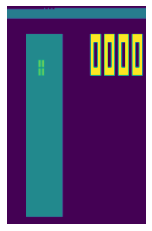

torch.Size([1, 1, 241, 153])
torch.Size([1, 1, 241, 153])


In [5]:
# Test out environment and utilities!
for s in [1,1,1,1,1,0,0,0,0,0]:
    frame = AtariSpace(possible_actions+1+s)
    origshape = current_frame.shape
    frameproc(frame)
    live_plot([current_frame])
    time.sleep(0.5)
print(origshape)
print(current_frame.shape)

In [6]:
# conv2d design testing
# ideally out convolutions should work with the input image size to only produce integers here. This will help a lot in the ConvTranspose2d decoder!
def conv_output_shape(h_w, kernel_size=1, stride=1, pad=0, dilation=1):
    from math import floor
    if type(kernel_size) is not tuple:
        kernel_size = (kernel_size, kernel_size)
    h = ((h_w[0] + (2 * pad) - ( dilation * (kernel_size[0] - 1) ) - 1 )/ stride) + 1
    w = ((h_w[1] + (2 * pad) - ( dilation * (kernel_size[1] - 1) ) - 1 )/ stride) + 1
    return h, w
t1 = conv_output_shape(current_frame.shape[2:4],kernel_size=5, stride=2)
t2 = conv_output_shape(t1,kernel_size=3, stride=2)
t3 = conv_output_shape(t2,kernel_size=3, stride=2)
print(t1)
print(t2)
print(t3)
flatsz = int(np.prod(t3)*32)
print(flatsz)

(119.0, 75.0)
(59.0, 37.0)
(29.0, 18.0)
16704


In [7]:
class VNet(nn.Module):
    #This will be a convolutional AE with tied encoder-decoder weights. Encoder can optionally be frozen.

    def __init__(self, output_dim=(512)):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=2),
            nn.Tanh(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2),
            nn.Tanh(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=2),
            nn.Tanh(),
            nn.Flatten(),
            nn.Linear(flatsz, 10000, bias=False),
            nn.Tanh(),
            nn.Linear(10000, output_dim, bias=False),
        )
        self.decoder = nn.Sequential(
            nn.Linear(output_dim, 10000, bias=False),
            nn.Tanh(),
            nn.Linear(10000,flatsz,bias=False),
            nn.Tanh(),
            # nn.Unflatten(1,(1,241,153)),
            nn.Unflatten(1,(32,int(t3[0]),int(t3[1]))),
            nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=3, stride=2),
            nn.Tanh(),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2),
            nn.Tanh(),
            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=5, stride=2),
        )
            
        # tie the weights
        for i in range(len(self.encoder)):
            ii = len(self.encoder)-i-1
            if hasattr(self.encoder[i],'weight'):
                if len(self.encoder[i].weight.shape)>2:
                    self.decoder[ii].weight = nn.Parameter(self.encoder[i].weight)
                else:
                    self.decoder[ii].weight = nn.Parameter(self.encoder[i].weight.t())

        # frozen versions
        self.encoderfrozen = copy.deepcopy(self.encoder)
        for p in self.encoderfrozen.parameters():
            p.requires_grad = False
        self.decoderfrozen = copy.deepcopy(self.decoder)
        for p in self.decoderfrozen.parameters():
            p.requires_grad = False

    def forward(self, input, model):
        if model == "online":
            return self.encoder(input)
        elif model == "frozen":
            return self.encoderfrozen(input)
        
    def backward(self, input, model):
        if model == "online":
            return self.decoder(input)
        elif model == "frozen":
            return self.decoderfrozen(input)
vnet = VNet().to(device)
print(vnet)

VNet(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(2, 2))
    (1): Tanh()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (3): Tanh()
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2))
    (5): Tanh()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=16704, out_features=10000, bias=False)
    (8): Tanh()
    (9): Linear(in_features=10000, out_features=512, bias=False)
  )
  (decoder): Sequential(
    (0): Linear(in_features=512, out_features=10000, bias=False)
    (1): Tanh()
    (2): Linear(in_features=10000, out_features=16704, bias=False)
    (3): Tanh()
    (4): Unflatten(dim=1, unflattened_size=(32, 29, 18))
    (5): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(2, 2))
    (6): Tanh()
    (7): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (8): Tanh()
    (9): ConvTranspose2d(16, 1, kernel_size=(5, 5), stride=(2, 2))
  )
  (encoderfrozen): Sequential(
    (0): Conv2d(1, 16, kernel_size=

In [14]:
VLoss = nn.MSELoss()
VOptim = optim.Adam(vnet.parameters(), lr=0.0001, weight_decay=1e-05)

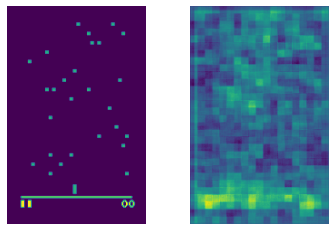

iteration: 9900


In [13]:
# quick test / pretrain of VNet

log = []
for i in range(10000):
    frame = AtariSpace(random.randint(0,1)+1+possible_actions)
    frameproc(frame)

    next_LV = vnet.forward(current_frame, model='online')
    recon_frame = vnet.backward(next_LV, model='online')

    vloss = VLoss(recon_frame,current_frame)
    log.append([vloss.to('cpu').detach()])
    VOptim.zero_grad()
    vloss.backward()
    VOptim.step()
    
    if i%100==0:
        live_plot([current_frame,recon_frame.detach()])
        print(f'iteration: {i}')
        
    del next_LV,recon_frame,vloss,frame
    
torch.save(vnet.state_dict(),'VNet_saved')

In [8]:
vnet.load_state_dict(torch.load('VNet_saved'))
vnet.eval()

VNet(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(2, 2))
    (1): Tanh()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (3): Tanh()
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2))
    (5): Tanh()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=16704, out_features=10000, bias=False)
    (8): Tanh()
    (9): Linear(in_features=10000, out_features=512, bias=False)
  )
  (decoder): Sequential(
    (0): Linear(in_features=512, out_features=10000, bias=False)
    (1): Tanh()
    (2): Linear(in_features=10000, out_features=16704, bias=False)
    (3): Tanh()
    (4): Unflatten(dim=1, unflattened_size=(32, 29, 18))
    (5): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(2, 2))
    (6): Tanh()
    (7): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (8): Tanh()
    (9): ConvTranspose2d(16, 1, kernel_size=(5, 5), stride=(2, 2))
  )
  (encoderfrozen): Sequential(
    (0): Conv2d(1, 16, kernel_size=

In [9]:
class HNet(nn.Module):
    # currently just fully connected (but high LR)
    
    def __init__(self, input_dim=(512), output_dim=(512)):
        super().__init__()
        self.online = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.Tanh(),
            nn.Linear(512, output_dim),
        )

        self.frozen = copy.deepcopy(self.online)
        for p in self.frozen.parameters():
            p.requires_grad = False

    def forward(self, input, model):
        if model == "online":
            return self.online(input)
        elif model == "frozen":
            return self.frozen(input)
        
hnet = HNet().to(device)
print(hnet)

HNet(
  (online): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): Tanh()
    (2): Linear(in_features=512, out_features=512, bias=True)
  )
  (frozen): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): Tanh()
    (2): Linear(in_features=512, out_features=512, bias=True)
  )
)


In [10]:
HLoss = nn.MSELoss()
HOptim = optim.SGD(hnet.parameters(),lr=0.1, weight_decay=1e-05)

In [11]:
class MNet(nn.Module):
    # simple fully connected with softmax at the end; optionally frozen
    
    def __init__(self, input_dim=(512), output_dim=(18)):
        super().__init__()
        self.online = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.Tanh(),
            nn.Linear(512, output_dim),
            GaussianNoise(),
            nn.Softmax(dim=0),
        )

        self.frozen = copy.deepcopy(self.online)
        for p in self.frozen.parameters():
            p.requires_grad = False

    def forward(self, input, model):
        if model == "online":
            return self.online(input)
        elif model == "frozen":
            return self.frozen(input)
        
mnet = MNet().to(device)
print(mnet)

MNet(
  (online): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): Tanh()
    (2): Linear(in_features=512, out_features=18, bias=True)
    (3): GaussianNoise()
    (4): Softmax(dim=0)
  )
  (frozen): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): Tanh()
    (2): Linear(in_features=512, out_features=18, bias=True)
    (3): GaussianNoise()
    (4): Softmax(dim=0)
  )
)


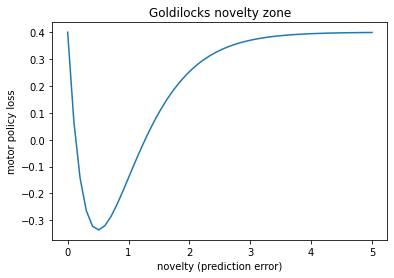

In [12]:
def erlang(x,k=2,l=2):
    return ((l**k)*(x**(k-1))*(math.e**(-l*x)))/math.factorial(k-1)
def MLoss(action,x):
    return 1 - torch.sum(action)*erlang(x) # note action sums to 1
x = np.linspace(0,5,num=50)
plt.plot(x,0.4-erlang(x))
plt.title("Goldilocks novelty zone")
plt.xlabel("novelty (prediction error)")
plt.ylabel("motor policy loss")

MOptim = optim.Adam(vnet.parameters(), lr=0.0001, weight_decay=1e-05)

In [24]:
# initialize state
frame = AtariSpace(19)
frameproc(frame)
current_LV = vnet.forward(current_frame, model='frozen')

# the complicated part.
# 0) reconstruct the frame from the current LV (just for viewing)
# 1a) choose next action from the current LV
# 1b) make a prediction from the current LV about the next LV
# 1c) reconstruct the next frame from the predicted LV
# 2) take the action and get the actual next frame+LV
# 3a) train VNet to reconstruct the current frame from the current LV
# 3b) train HNet to predict next LV from the current LV
# 3c) train MNet to maximize HLoss
log = []
t = time.time()
for i in range(1000):
    
    current_action = mnet.forward(current_LV, model='online')
    predicted_LV = hnet.forward(current_LV,model='online')
    recon_frame = vnet.backward(current_LV, model='online')
    predicted_frame = vnet.backward(predicted_LV.detach(), model='frozen')
    
    vloss = VLoss(recon_frame,current_frame)
    VOptim.zero_grad()
    vloss.backward()
    VOptim.step()
    
    frame = AtariSpace(np.argmax(current_action.to('cpu').detach()))
    frameproc(frame)
    next_LV = vnet.forward(current_frame, model='frozen')
    
    hloss = HLoss(predicted_LV,next_LV)
    HOptim.zero_grad()
    hloss.backward()
    HOptim.step()
    mloss = MLoss(current_action,hloss.detach())
    MOptim.zero_grad()
    mloss.backward()
    MOptim.step()
    
    log.append([vloss.to('cpu').detach(), hloss.to('cpu').detach(), mloss.to('cpu').detach()])
    
    live_plot([current_frame,recon_frame,predicted_frame])
    current_LV = next_LV
    
    del current_action, predicted_LV, recon_frame, predicted_frame, next_LV, vloss, hloss, mloss

elapsed = time.time() - t
print(elapsed)

KeyboardInterrupt: 

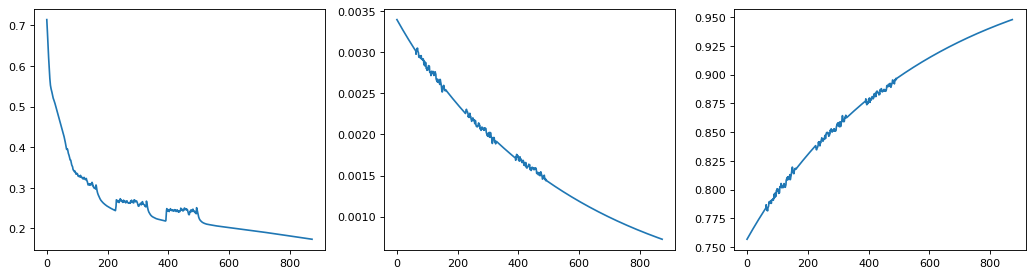

In [23]:
plt.figure(figsize=(16, 4), dpi=80)
log = np.asarray(log)
plt.subplot(1,3,1)
plt.plot(log[:,0])
plt.subplot(1,3,2)
plt.plot(log[:,1])
plt.subplot(1,3,3)
plt.plot(log[:,2])
#plt.legend(['v','h','m'])